In [1]:
# matplotlib inline plotting
%matplotlib inline
# make inline plotting higher resolution
%config InlineBackend.figure_format = 'svg'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.ensemble import RandomForestClassifier

plt.style.use('dark_background')

## Kaggle Knowledge Competition: Titanic - Machine Learning from Disaster

My solution attempt at predicting which passengers survived the Titanic shipwreck.

Data and additional information is available at [Kaggle](https://www.kaggle.com/c/titanic)

### Step 1: Read data

In [3]:
train = pd.read_csv('train.csv', index_col='PassengerId')
train.index.name = None
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test = pd.read_csv('test.csv', index_col='PassengerId')
test.index.name = None
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# I will need to do the same operations for each data-set - thus combining them in an iterable list.
combined = [train, test]

### Plotting

It is always a great idea to plot based on different sorting parameters. We see below that there are a lot of sources of variation, which can be used to make the model more exact.

- __Age__ 
    - Age is a large source of variation in terms survivability.
    - To better explain this variation, we're going to use age-groups _(one-hot encoded)_ instead of integer age.
    
- __Gender__ 
    - Gender is a large source of variation in terms survivability.
    - To better explain this variation we can use regular-expressions on the Name column to find out the social status of the passengers.
    - This should also help explain some variation in which class they're traveling on.
    
- __Fare__
    - Fare is of course very right-skewed as some may have payed large sums for luxurious accomodation and 3rd class passengers may have payed very little.
    - There's also the issue of staff - whom travel for free.
    - We bin Fare into quartiles _(and group staff in their own section)_

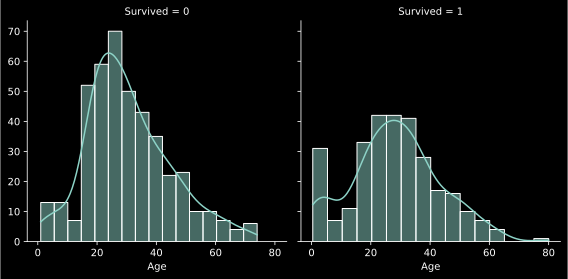

In [6]:
f = sns.FacetGrid(col='Survived', data=train, height=4)
f.map(sns.histplot, 'Age', kde=True)
plt.show()

In [7]:
# Group interval Age variabel into categories.
# Young and young-adult is chosen, because many in the 12-25 age group would have been staff (maids, cooks etc.)
intervals = [0, 5, 12, 20, 30, 55, 120]
category = ['Babies', 'Children', 'Young', 'Young-Adult', 'Adult', 'Senior']

for df in combined:
    df['AgeCategory'] = pd.cut(df['Age'], intervals, labels=category)

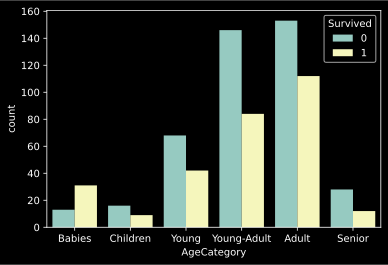

In [8]:
sns.countplot(data=train, x='AgeCategory', hue='Survived')
plt.show()

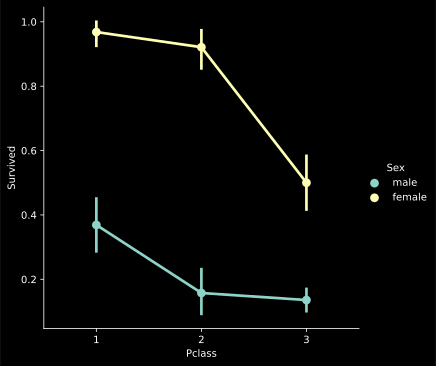

In [9]:
sns.catplot(data=train, y='Survived', x='Pclass', hue='Sex', kind='point')
plt.show()

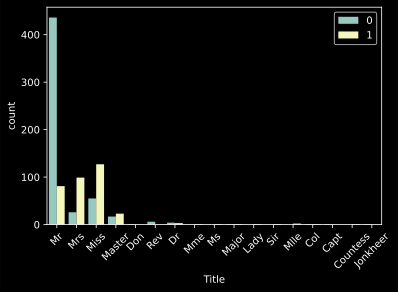

In [10]:
for df in combined:
    df['Title'] = df['Name'].apply(lambda x: re.search(string=x, pattern=' ([A-Z][a-z]+)\.').group(1))

sns.countplot(data=train, x='Title', hue='Survived')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

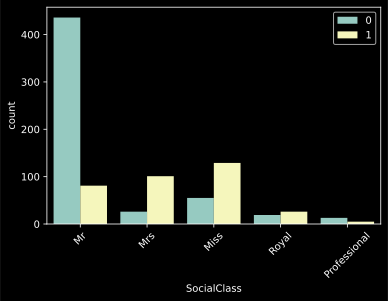

In [11]:
SocialClass = {'Mr': 'Mr',
               'Mrs': 'Mrs',
               'Miss': 'Miss',
               'Master': 'Royal',
               'Don': 'Royal',
               'Rev': 'Professional',
               'Dr': 'Professional',
               'Mme': 'Mrs',
               'Ms': 'Mrs',
               'Major': 'Professional',
               'Lady': 'Royal',
               'Sir': 'Royal',
               'Mlle': 'Miss',
               'Col': 'Professional',
               'Capt': 'Professional',
               'Countess': 'Royal',
               'Jonkheer': 'Royal'}

for df in combined:
    df['SocialClass'] = df['Title'].map(SocialClass)
    
sns.countplot(data=train, x='SocialClass', hue='Survived')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

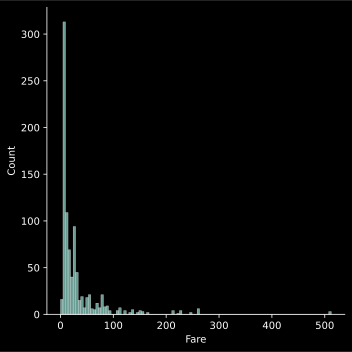

In [12]:
sns.displot(data=train, x='Fare')
plt.show()

In [13]:
# The fare data is grouped into Quartiles (exception of zero(staff))
for df in combined:
    intervals = [-1, 
                 0, 
                 df.Fare.quantile(q=0.25), 
                 df.Fare.quantile(q=0.5), 
                 df.Fare.quantile(q=0.75), 
                 df.Fare.max() + 1]

    category = ['Zero', 'Q1', 'Q2', 'Q3', 'Q4']

    df['FareCategory'] = pd.cut(df.Fare, intervals, labels=category)

### Finishing feature engineering

In [14]:
# drop irrelevant columns
for df in combined:
    df = df.drop(columns=['Name', 'Ticket', 'Fare', 'Age', 'Title', 'Cabin'], inplace=True)

In [15]:
# use one-hot encoding
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

In [16]:
X_train = train.drop(columns='Survived')
Y_train = train['Survived']
X_test = test

In [17]:
mdl = RandomForestClassifier()
mdl.fit(X_train, Y_train)
Y_pred = mdl.predict(X_test)
print(f'RandomForest cross-validation score: {np.round(mdl.score(X_train, Y_train), 4) * 100}%')

RandomForest cross-validation score: 90.57%


In [18]:
pd.DataFrame({'PassengerId': test.index, 'Survived': Y_pred}).to_csv('submission.csv', index=False)